<a href="https://colab.research.google.com/github/zinabu-dot/COVID-19-Modeling_AA/blob/master/Zinabu_Melese.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Assignment for Senior Data Scientist RaboResearch Financial markets & Economic research**
---
* The business problem appears to focus on making an **investment** on McDonald’s stock (MCD) if at least **10% profit** is about to earn in the next 10 working days following the purchase day. 

* Considering the nature of the challenge (as already stated in the assignment document), the assignment is a **classification (binary)** problem. 

* The dataset for this challenge are based on [Raboresearch_label_data](https://docs.google.com/uc?export=download&id=1cp5YFvszZuFw3IusD6EWKfL8AeCSf9Lg) and [Raboresearch_feature_data](https://docs.google.com/uc?export=download&id=1BawB1Zm43rmk7HMftFWnwizN-cyd7nnD) and can be accessed using the following commands.

In [6]:
!wget -O label_raw.csv 'https://docs.google.com/uc?export=download&id=1cp5YFvszZuFw3IusD6EWKfL8AeCSf9Lg' -q --show-progress
!wget -O features.zip 'https://docs.google.com/uc?export=download&id=1BawB1Zm43rmk7HMftFWnwizN-cyd7nnD' -q --show-progress 
!unzip features.zip 
!ls

label_raw.csv       100%[===================>] 937.80K  --.-KB/s    in 0.05s   
features.zip        100%[===================>]   2.03M  --.-KB/s    in 0.06s   
Archive:  features.zip
  inflating: features.xlsx           
features.xlsx  features.zip  label_raw.csv  sample_data


---
## **Import** libraries
---

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline 

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier

---
# Reading the label data
---

In [75]:
# reading the label data
df_lab = pd.read_csv('label_raw.csv')

# checking the datatype of each column
df_lab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13728 entries, 0 to 13727
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          13728 non-null  object 
 1   Open          13728 non-null  float64
 2   High          13728 non-null  float64
 3   Low           13728 non-null  float64
 4   Close         13728 non-null  float64
 5   Volume        13728 non-null  int64  
 6   Dividends     13728 non-null  float64
 7   Stock Splits  13728 non-null  float64
dtypes: float64(6), int64(1), object(1)
memory usage: 858.1+ KB


In [76]:
df_lab.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,7/5/1966,0.0,0.004074,0.003982,0.004013,388800,0.0,0.0
1,7/6/1966,0.0,0.004227,0.003982,0.004227,687200,0.0,0.0
2,7/7/1966,0.0,0.004335,0.004044,0.004074,1853600,0.0,0.0
3,7/8/1966,0.0,0.004120,0.003982,0.004120,1238400,0.0,0.0
4,7/11/1966,0.0,0.004227,0.004059,0.004105,655200,0.0,0.0


From the above output, it can be seen that the **'Date'** column is a **string type**. It has to be converted into **datetime object**.

In [77]:
def to_datetime():
  # convert the string date to datetime format
  df_lab['Date'] = pd.to_datetime(df_lab['Date'])

  # get the names of the week days
  df_lab['weekday_name'] = df_lab['Date'].dt.day_name()

  # filtering on working days 
  df_lab_wd = df_lab[(df_lab['weekday_name']!='Saturday') | (df_lab['weekday_name']!='Sunday')]

  # As the sale is made on weekdays 
  return df_lab_wd

# let's give the same name for the data obtained from the function as it was named before

df_lab = to_datetime()
df_lab.shape

(13728, 9)

# **Visualize** the missing values in each column for the sake of **data qualitiy management**

Date            0.0
Open            0.0
High            0.0
Low             0.0
Close           0.0
Volume          0.0
Dividends       0.0
Stock Splits    0.0
weekday_name    0.0
dtype: float64


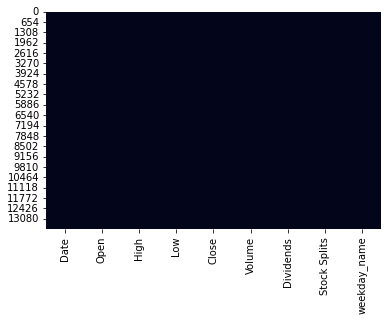

In [78]:
def missing_heatmap():
  # heatmap plot to see the position/location of missing values (if any)
  sns.heatmap(df_lab.isnull(), cbar=False)

  # print the proportion of missing values in each column
  print(df_lab.isnull().mean())
missing_heatmap()

As per the results above, the label data is _**clean in terms of missing values**_. 

# **Dichotomize the investiment as positive and negative**
---
**Positive** if $profit$ reads at **least 10% with in 10 working days** following a purchase day, **negative** otherwise.

Take the maximum of the lowest selling prices in the 10 working days immediate to purchase day: 

<center> $sell = \max{\{sell_{t+1}, ..., sell_{t+10}\}}$ <center/> 

<justify> where $t$ is the purchase day. <justify/>

then calculate the profit percentage as:

<center> $profit = \frac{sell - purchase_t}{purchase_t}\times 100$ <center/>


In [79]:
def calc_profit():
  d = 10
  df_lab['profit'] = ((pd.Series(df_lab['Low']).rolling(d)).max().shift(-d) - pd.Series(df_lab['High']))/pd.Series(df_lab['High'])
  df_lab_pro = df_lab.dropna()
  return df_lab_pro
df_lab = calc_profit()
df_lab.head()


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,weekday_name,profit
0,1966-07-05,0.0,0.004074,0.003982,0.004013,388800,0.0,0.0,Tuesday,-0.003759
1,1966-07-06,0.0,0.004227,0.003982,0.004227,687200,0.0,0.0,Wednesday,-0.039855
2,1966-07-07,0.0,0.004335,0.004044,0.004074,1853600,0.0,0.0,Thursday,-0.063604
3,1966-07-08,0.0,0.004120,0.003982,0.004120,1238400,0.0,0.0,Friday,-0.014870
4,1966-07-11,0.0,0.004227,0.004059,0.004105,655200,0.0,0.0,Monday,-0.047101


In [80]:
# Labeling the investment based on the minimum of 10% profit
def investment_label(gain):
  if gain >= 0.1:
    return 'positive'
  else:
    return 'negative'
df_lab['label'] = df_lab['profit'].map(investment_label)


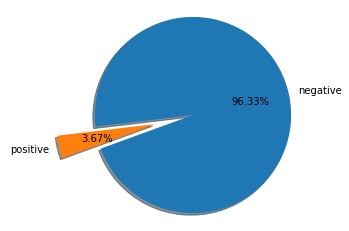

In [81]:
# Distribution of the positive and negative investments 
def label_dist():

	df_perc = pd.DataFrame(df_lab.groupby('label')['label'].count() * 100/(df_lab.groupby('label')['label'].count().sum()))\
    	.rename(columns={'label':'animal_percent'}).reset_index()


	explode = (0, 0.4)  

	fig1, ax1 = plt.subplots()
	ax1.pie(df_perc['animal_percent'], explode=explode,
	 	labels=df_perc['label'], autopct='%1.2f%%',
        	shadow=True, startangle=200)
	ax1.axis('equal')
 
if __name__ == "__main__":
  label_dist()


# Reading features data

In [82]:
df_feat = pd.ExcelFile('features.xlsx')
df_feat.sheet_names

# Reading the data in each sheets
df_featA = pd.read_excel('features.xlsx', sheet_name=None)

In [83]:
df_gdp = df_featA[df_feat.sheet_names[3]]

In [84]:
df_gdp.rec_vld_dts.unique()

array(['2007-12-31T00:00:00.000000000', '1994-03-31T00:00:00.000000000',
       '1997-06-30T00:00:00.000000000', '1992-11-30T00:00:00.000000000',
       '2007-05-31T00:00:00.000000000', '1995-07-31T00:00:00.000000000',
       '1992-04-30T00:00:00.000000000', '2001-06-30T00:00:00.000000000',
       '2008-09-30T00:00:00.000000000', '1993-08-31T00:00:00.000000000',
       '2002-03-31T00:00:00.000000000', '1994-12-31T00:00:00.000000000',
       '2000-11-30T00:00:00.000000000', '1993-01-31T00:00:00.000000000',
       '1994-05-31T00:00:00.000000000', '2008-02-29T00:00:00.000000000',
       '2001-08-31T00:00:00.000000000', '1995-09-30T00:00:00.000000000',
       '1997-08-31T00:00:00.000000000', '2007-07-31T00:00:00.000000000',
       '1992-06-30T00:00:00.000000000', '1995-02-28T00:00:00.000000000',
       '2001-01-31T00:00:00.000000000', '1993-10-31T00:00:00.000000000',
       '2002-05-31T00:00:00.000000000', '1993-03-31T00:00:00.000000000',
       '2006-12-31T00:00:00.000000000', '2001-10-31

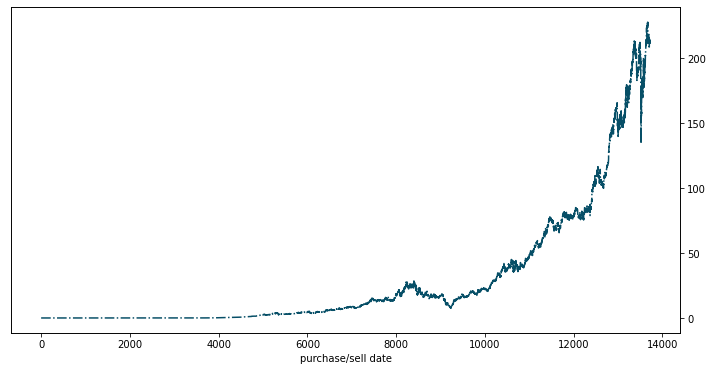

In [85]:
df_lab['Close'].plot(style='-.', xlabel='purchase/sell date',
                     ylabel='Close price', figsize=(12,6), color='#074F67', secondary_y=True)

In [86]:
# replace the (target) text labels by numberic scores, so that the state-of-the-art method can understand them
df_lab['label'] = df_lab['label'].replace({'negative':0, 'positive':1})

In [87]:
# Considering 'Open' price and Volume as features 
# Checking the strength of the correlation between 'Open' and Volume, in order to avoid collinearity issue in 
df_lab[['Open', 'Volume']].corr()

,Open,Volume
Open,1.00000,0.11519
Volume,0.11519,1.00000


# **Scaling features' values**

---
 * Standardize values for less memory usage and precision 

In [88]:
def feat_scale():
  scaler = MinMaxScaler()
  transform = scaler.fit_transform(df_lab[['Open', 'Volume']])
  df_feat = pd.DataFrame(data=transform, columns=['Open', 'Volume'])
  return df_feat
df_feat = feat_scale()
df_feat.tail()

,Open,Volume
13713,0.926092,0.011500
13714,0.929890,0.028782
13715,0.937094,0.018609
13716,0.929759,0.020786
13717,0.922293,0.029473


In [89]:
X_train, X_test, y_train, y_test = train_test_split(df_feat, df_lab['label'], test_size=0.25, stratify=df_lab['label'])

In [90]:
nb = GaussianNB()
lr = LogisticRegression(max_iter = 2000)
dt = DecisionTreeClassifier(max_depth=10, random_state = 42)
rf = RandomForestClassifier(max_depth=5, random_state = 42)
svc = SVC(probability = True, C=1)
knn = KNeighborsClassifier(n_neighbors=7)
xgb = XGBClassifier(random_state =1)
# vot = VotingClassifier(
#     estimators = [('nb',nb), ('lr',lr), ('dt',dt), ('rf',rf), ('svc',svc), ('knn',knn), ('xgb',xgb)],
#     voting = 'soft'
# )

models = [nb, lr, dt, rf,  svc, knn, xgb ] # lr, vot, xgb, nb, svc,
models_name = [
   "Naive Bayes",
   "Logistic Regression",
    "Decision Tree",
    "Random Forest",
    "SVM",
    "K-Nearest Neighbor",
    "XGBoost",
    #"Voting"
]

In [91]:
## Results based on Cross validation
results_cv = {}

for index, model in enumerate(models):
    cv = cross_val_score(model, X_train, y_train, cv=10)  # 10 fold cross validation
    results_cv[models_name[index]] = cv.mean() * 100.0
    print("Baseline using", models_name[index], "=", cv.mean() * 100.0, "%", "with std:", cv.std())

Baseline using Naive Bayes = 96.30637580212739 % with std: 0.0004352699270010648
Baseline using Logistic Regression = 96.32583105504568 % with std: 0.0003747357753551839
Baseline using Decision Tree = 95.70374508891938 % with std: 0.0031862144510243044
Baseline using Random Forest = 96.32583105504568 % with std: 0.0003747357753551839
Baseline using SVM = 96.32583105504568 % with std: 0.0003747357753551839
Baseline using K-Nearest Neighbor = 96.24808567117785 % with std: 0.0013802447942685633
Baseline using XGBoost = 96.32583105504568 % with std: 0.0003747357753551839


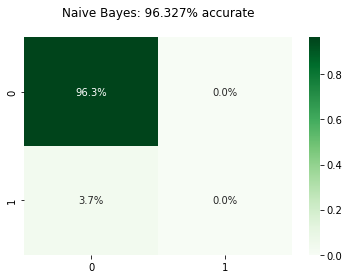

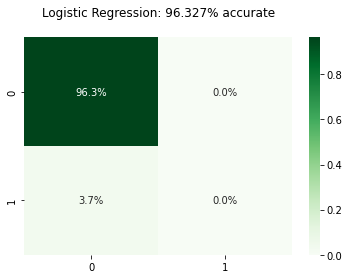

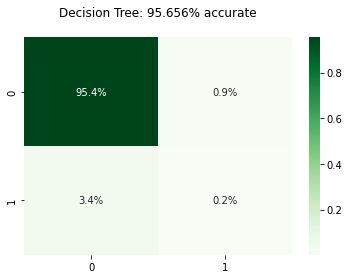

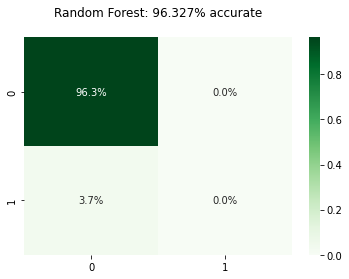

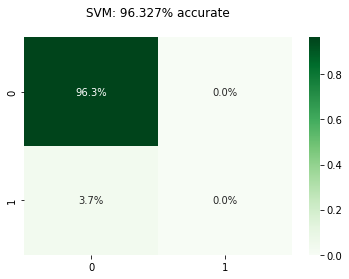

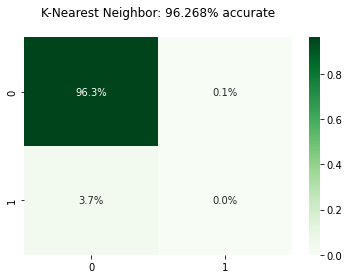

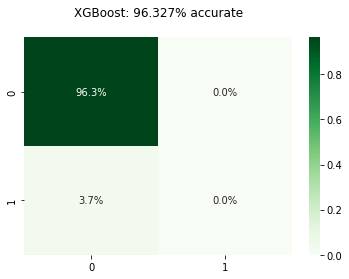

In [92]:
# results without CV
results = {}

for index, model in enumerate(models):
    model.fit(X_train, y_train)
    predict = (model.predict(X_test) > 0.8).astype(int)
    confuse = confusion_matrix(y_test, predict)
    accur = accuracy_score(y_test, predict)
    results[models_name[index]] = accur * 100.0
    
    title = models_name[index] + ": " + "{:.3f}%".format(accur*100) + " accurate\n"
    ax = sns.heatmap(confuse/np.sum(confuse), annot=True, fmt='.1%', cmap="Greens")
    ax.set_title(title)
    plt.show()

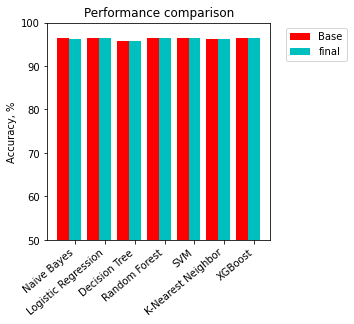

In [116]:
x = np.arange(len(results))

plt.figure(figsize=(4,4))
ax = plt.subplot(111)
plt.bar(x, results.values(), width=0.4, color="r", align="center")
ax.bar(x+0.4, results_cv.values(), width=0.4, color="c", align="center")
ax.legend(("Base", "final"), bbox_to_anchor=(1.05, 1))
plt.ylim((50, 100))
plt.xticks(x+0.4, results.keys())
plt.title("Performance comparison")
plt.xticks(rotation=40, horizontalalignment="right")
plt.ylabel('Accuracy, %')
plt.show()

## **Mitigation for data imblance problem**
___
* From the above results, it looks the models are predicting the majority class.
* I consider down sampling approach (down sample the majority (negative)class to the size of positive investments) as a mitigation.

In [94]:
# Get the negative and positive investiments separately
df_label_0 = df_lab[df_lab.label==0]
df_label_1 = df_lab[df_lab.label==1]

In [95]:
# randomly sample down the negative investments
df_label_0_under = df_label_0.sample(len(df_label_1))
df_label_0_under.shape

(504, 11)

In [96]:
# Merge the two data frames
df_merged = pd.concat([df_label_0_under, df_label_1], axis=0)
df_merged.shape

(1008, 11)

In [97]:
df_merged.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,weekday_name,profit,label
6202,1991-03-05,4.518734,4.605300,4.484108,4.587986,4240000,0.02125,0.0,Tuesday,0.041354,0
8058,1998-07-08,21.602187,21.620494,21.181127,21.382504,4408200,0.00000,0.0,Wednesday,-0.004233,0
10416,2007-11-20,39.501120,39.642679,39.029265,39.420231,9414700,0.00000,0.0,Tuesday,0.010883,0
9328,2003-07-28,12.924778,12.997661,12.724347,12.912630,4591600,0.00000,0.0,Monday,0.088318,0
6731,1993-04-06,7.288112,7.305758,7.076350,7.182231,4988400,0.00000,0.0,Tuesday,-0.019324,0


In [118]:
X_train, X_test, y_train, y_test = train_test_split(df_merged[['Open', 'Volume']],
                                                    df_merged['label'], test_size=0.25)

In [119]:
results_cv_down = {}

for index, model in enumerate(models):
    cv = cross_val_score(model, X_train, y_train, cv=10)  # 10 fold cross validation
    results_cv_down[models_name[index]] = cv.mean() * 100.0
    print("Baseline using", models_name[index], "=", cv.mean() * 100.0, "%", "with std:", cv.std())

Baseline using Naive Bayes = 56.20175438596491 % with std: 0.05486356507323781
Baseline using Logistic Regression = 50.26666666666667 % with std: 0.003265986323710925
Baseline using Decision Tree = 72.33333333333334 % with std: 0.05457674517767603
Baseline using Random Forest = 75.91052631578947 % with std: 0.054670869486888964
Baseline using SVM = 58.724561403508766 % with std: 0.04875684797733051
Baseline using K-Nearest Neighbor = 56.333333333333336 % with std: 0.06821764636869955
Baseline using XGBoost = 77.37017543859649 % with std: 0.043529808864411955


classification report for Naive Bayes 
               precision    recall  f1-score   support

           0       0.67      0.44      0.53       124
           1       0.59      0.79      0.68       128

    accuracy                           0.62       252
   macro avg       0.63      0.62      0.61       252
weighted avg       0.63      0.62      0.61       252



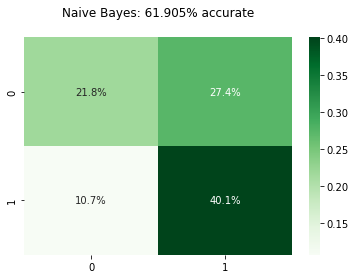

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


classification report for Logistic Regression 
               precision    recall  f1-score   support

           0       0.49      1.00      0.66       124
           1       0.00      0.00      0.00       128

    accuracy                           0.49       252
   macro avg       0.25      0.50      0.33       252
weighted avg       0.24      0.49      0.32       252



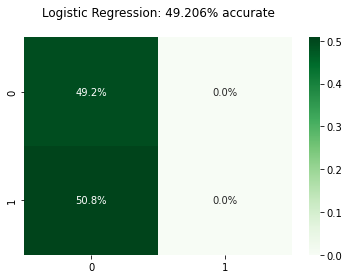

classification report for Decision Tree 
               precision    recall  f1-score   support

           0       0.70      0.73      0.72       124
           1       0.73      0.70      0.71       128

    accuracy                           0.71       252
   macro avg       0.71      0.71      0.71       252
weighted avg       0.71      0.71      0.71       252



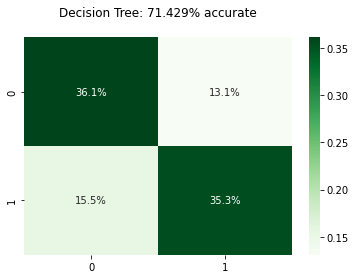

classification report for Random Forest 
               precision    recall  f1-score   support

           0       0.80      0.73      0.76       124
           1       0.76      0.83      0.79       128

    accuracy                           0.78       252
   macro avg       0.78      0.78      0.78       252
weighted avg       0.78      0.78      0.78       252



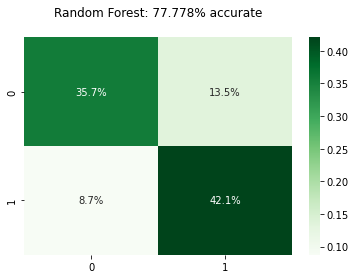

classification report for SVM 
               precision    recall  f1-score   support

           0       0.56      0.65      0.60       124
           1       0.60      0.50      0.54       128

    accuracy                           0.58       252
   macro avg       0.58      0.58      0.57       252
weighted avg       0.58      0.58      0.57       252



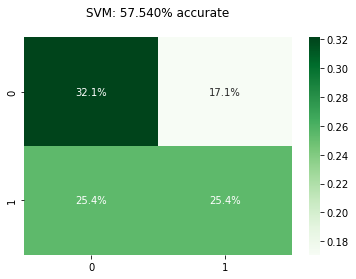

classification report for K-Nearest Neighbor 
               precision    recall  f1-score   support

           0       0.53      0.53      0.53       124
           1       0.54      0.54      0.54       128

    accuracy                           0.54       252
   macro avg       0.54      0.54      0.54       252
weighted avg       0.54      0.54      0.54       252



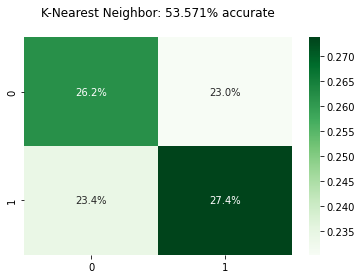

classification report for XGBoost 
               precision    recall  f1-score   support

           0       0.77      0.74      0.76       124
           1       0.76      0.79      0.77       128

    accuracy                           0.77       252
   macro avg       0.77      0.77      0.77       252
weighted avg       0.77      0.77      0.77       252



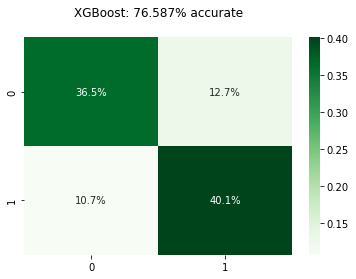

In [120]:
results_down = {}

for index, model in enumerate(models):
    model.fit(X_train, y_train)
    predict = (model.predict(X_test) > 0.7)
    confuse = confusion_matrix(y_test, predict)
    accur = accuracy_score(y_test, predict)
    results_down[models_name[index]] = accur * 100.0
    
    print(f'classification report for {models_name[index]} \n',classification_report(y_test, predict))
    title = models_name[index] + ": " + "{:.3f}%".format(accur*100) + " accurate\n"
    ax = sns.heatmap(confuse/np.sum(confuse), annot=True, fmt='.1%', cmap="Greens")
    ax.set_title(title)
    plt.show()

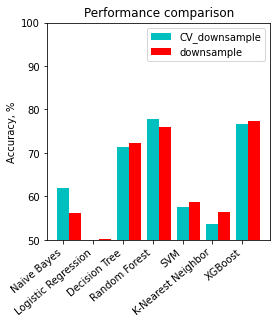

In [124]:
x = np.arange(len(results_down))

plt.figure(figsize=(4,4))
ax = plt.subplot(111)
plt.bar(x, results_down.values(), width=0.4, color="c", align="center")
ax.bar(x+0.4, results_cv_down.values(), width=0.4, color="r", align="center")
ax.legend(("CV_downsample", "downsample"), bbox_to_anchor=(1., 1))
plt.ylim((50, 100))
plt.xticks(x, results_down.keys())
plt.title("Performance comparison")
plt.xticks( rotation=40, horizontalalignment="right")
plt.ylabel('Accuracy, %')
plt.show()


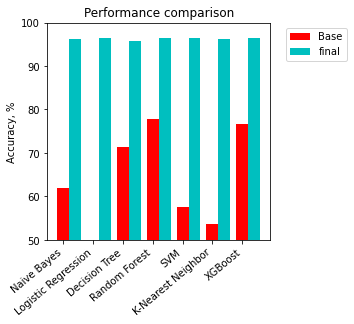

In [122]:
x = np.arange(len(results_down))

plt.figure(figsize=(4,4))
ax = plt.subplot(111)
plt.bar(x, results_down.values(), width=0.4, color="r", align="center")
ax.bar(x+0.4, results_cv.values(), width=0.4, color="c", align="center")
ax.legend(("Base", "final"), bbox_to_anchor=(1.05, 1))
plt.ylim((50, 100))
plt.xticks(x, results_down.keys())
plt.title("Performance comparison")
plt.xticks(rotation=40, horizontalalignment="right")
plt.ylabel('Accuracy, %')
plt.show()